In [9]:
from dotenv import load_dotenv
import os

from langchain_groq import ChatGroq

load_dotenv()

True

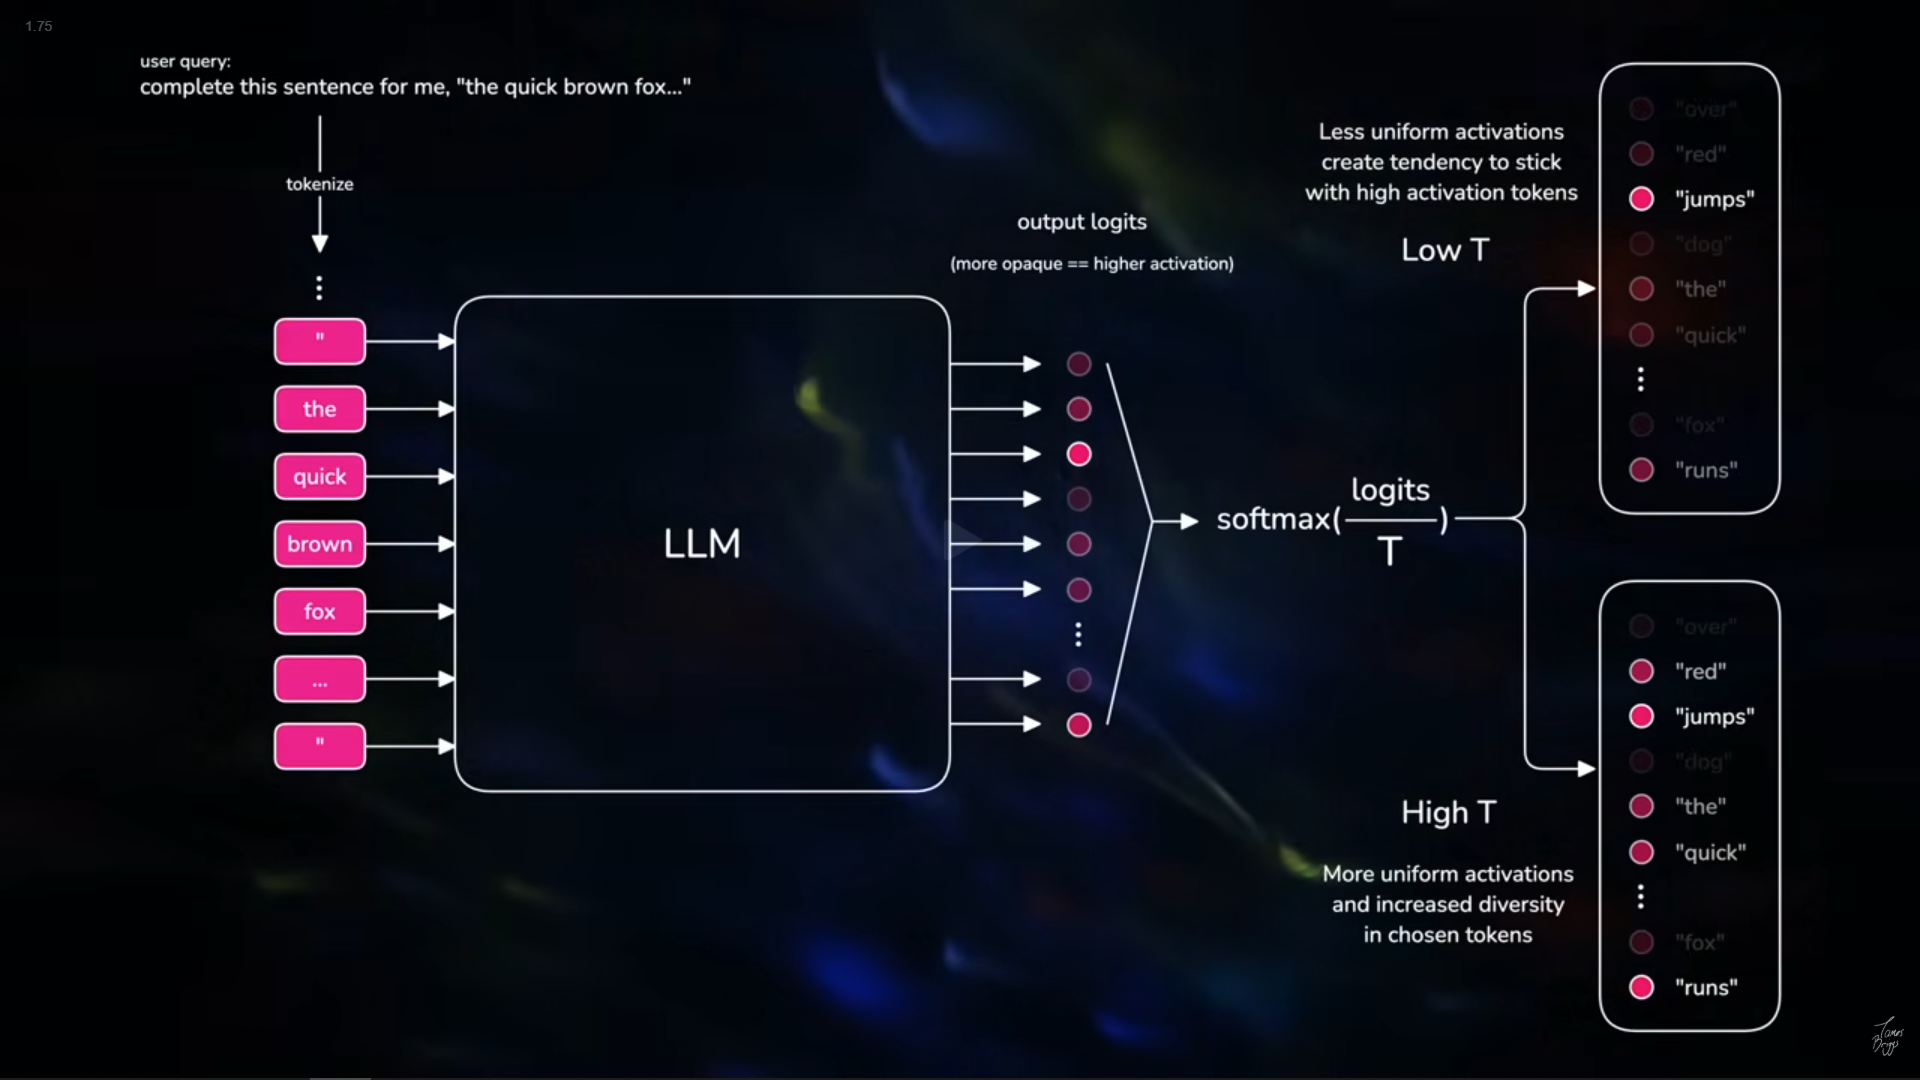

In [17]:
llm = ChatGroq(model="openai/gpt-oss-120b",
            temperature = 0.8)

In [18]:
with open("article.txt", "r", encoding="utf-8") as f:
    article = "".join(f.readlines()) # -> to read line by line
    
article[:49]

"We believe AI's short—to mid-term future belongs "

```
You are a helpful AI assistant, you will do XYZ.    | SYSTEM PROMPT

User: Hi, what is the capital of Australia?         | USER PROMPT
AI: It is Canberra                                  | AI PROMPT
User: When is the best time to visit?               | USER PROMPT
```

the way you tuse it is:
1. you import the prompt template
2. use `.from_template`
3. it has 2 parameters
   1. the full string with variables in {}
   2. the `input_varibale` to decalre that whats in {} is a variable

In [20]:
from langchain_core.prompts import (
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template(
    "You are an AI assistant named {name} that helps generate article titles.",
    input_variables=['name']
)

# the user prompt is provided by the user, in this case however the only dynamic
# input is the article
user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a name for a article.
The article is here for you to examine {article}

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.""",
    input_variables=["article"]
)

In [13]:
user_prompt.format(article="===> TESSSSTTT <=== ")

HumanMessage(content='You are tasked with creating a name for a article.\nThe article is here for you to examine ===> TESSSSTTT <=== \n\nThe name should be based of the context of the article.\nBe creative, but make sure the names are clear, catchy,\nand relevant to the theme of the article.\n\nOnly output the article name, no other explanation or\ntext can be provided.', additional_kwargs={}, response_metadata={})

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

first_prompt = ChatPromptTemplate.from_messages(
                    [system_prompt, user_prompt]
                    )

print(first_prompt.format(
    article="===> TESSSSTTT <=== ", 
    name="jarvis"))

System: You are an AI assistant named jarvis that helps generate article titles.
Human: You are tasked with creating a name for a article.
The article is here for you to examine ===> TESSSSTTT <=== 

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.


We'll be using **L**ang**C**hain **E**xpression **L**anguage (LCEL) to construct our chain.

For now, all we need to know is that we define our inputs with the first dictionary segment (ie `{"article": lambda x: x["article"]}`)
 
then we use the pipe operator (`|`) to say that the output from the left of the pipe will be fed into the input to the right of the pipe.

In [ ]:
# This chain will perform the steps **prompt formatting > llm generation > get output**.
chain_one = (
    # a dict of the input_variables to go to the prompt (MUST USE LAMBDA)
    {
        "article": lambda x: x["article"],
        "name": lambda x: x["name"]
    }
    
    # goes to prmopt
    | first_prompt
    
    # the prompt goes to the llm
    | llm
    
    # take the llm's output (.content)
    | {"article_title": lambda x: x.content}
)

In [22]:
article_title_one = chain_one.invoke({
    "article": article,
    "name": 'jarvis'
})

article_title_one

{'article_title': 'Neuro‑Symbolic Agents: Merging LLMs with Code to Power the Future of AI'}

=========================================================================

In [23]:
# system prompt
system_prompt = SystemMessagePromptTemplate.from_template(
    "You are an AI assistantthat helps generate article titles."
)

# user's prompt
second_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a description for
the article. The article is here for you to examine:

---

{article}

---

Here is the article title '{article_title}'.

Output the SEO friendly article description. Do not output
anything other than the description.""",
    
    input_variables=["article", "article_title"]
)

# from_message( [system, user] )
second_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    second_user_prompt
])

In [25]:
chain_two = (
    # 1. the dict of input_variable
    {   # MUST USE LAMBDA
        "article": lambda x: x["article"],
        "article_title": lambda x: x["article_title"]
    }
    # 2. send these variables to the prompt (full one)
    | second_prompt
    # 3. send the prompt to the llm
    | llm
    # 4. get the llm's output
    | {"summary": lambda x: x.content}
)

In [27]:
article_description_msg = chain_two.invoke(
    {
        "article": article,
        "article_title": lambda x: x["article_title_one"]
    }
)

article_description_msg

{'summary': 'Discover why AI agents—neuro‑symbolic systems that combine large language models with executable code—are the next big breakthrough in artificial intelligence. This comprehensive guide explains the fundamentals of neuro‑symbolic architectures, contrasts neural and symbolic strengths, explores pioneering frameworks like MRKL and ReAct, and reveals how agents can perform web searches, math, API calls, and more. Learn how agents will shape the short‑ to mid‑term AI landscape and pave the way toward future AGI, plus get a sneak peek at advanced multi‑agent and deterministic workflows. Stay ahead with insights on building powerful, real‑world AI agents and sign up for the Aurelio AI newsletter for upcoming courses.'}

In [28]:
third_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a new paragraph for the
article. The article is here for you to examine:

---

{article}

---

Choose one paragraph to review and edit. During your edit
ensure you provide constructive feedback to the user so they
can learn where to improve their own writing.""",
    input_variables=["article"]
)

# prompt template 3: creating a new paragraph for the article
third_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    third_user_prompt
])

We create a pydantic object describing the output format we need. This format description is then passed to our model using the `with_structured_output` method:

Pydantic is a Python library for data validation and settings management using type hints.

**Core Idea:**

You define data models using Python type annotations, and Pydantic:
- Validates input data
- Parses/coerces types automatically
- Raises structured errors if validation fails

In [30]:
from pydantic import BaseModel, Field

class Paragraph(BaseModel):
    original_paragraph: str = Field(description="The original paragraph")
    edited_paragraph: str = Field(description="The improved edited paragraph")
    feedback: str = Field(description=(
        "brief constructive feedback on the original paragraph and a numerical score"
    ))
    
# here we overwrite the original strucutre of the model to our own
structured_llm = llm.with_structured_output(Paragraph)

In [31]:
# chain 3: inputs: article / output: article_para
chain_three = (
    {"article": lambda x: x["article"]}
    | third_prompt
    | structured_llm
    | {
        "original_paragraph": lambda x: x.original_paragraph,
        "edited_paragraph": lambda x: x.edited_paragraph,
        "feedback": lambda x: x.feedback
    }
)

In [32]:
out = chain_three.invoke({"article": article})
out

{'original_paragraph': "Pure neural architectures struggle with many seemingly simple tasks. For example, an LLM *cannot* provide an accurate answer if we ask it for today's date.\n\nRetrieval Augmented Generation (RAG) is commonly used to provide LLMs with up-to-date knowledge on a particular subject or access to proprietary knowledge.",
 'edited_paragraph': "Pure neural architectures often stumble on tasks that appear trivial to humans. For instance, an LLM *cannot* reliably tell you today's date without external assistance. To overcome this limitation, Retrieval‑Augmented Generation (RAG) is frequently employed, enabling LLMs to fetch up‑to‑date information or proprietary knowledge on demand.",
 'feedback': 'The original paragraph conveyed the main idea but suffered from a choppy structure and vague phrasing. I combined the two sentences into a smoother flow, clarified that the date issue is a reliability problem, and introduced RAG as a solution with a more precise description. Add

In [33]:
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
from langchain_core.prompts import PromptTemplate

image_prompt = PromptTemplate(
    input_variables=["article"],
    template=(
        "Generate a prompt with less then 500 characters to generate an image "
        "based on the following article: {article}"
    )
)